In [ ]:
%matplotlib widget

# Standard imports
import os
from pathlib import Path
from collections import OrderedDict

# Plotting and processing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fitting 
from lmfit import Model, Parameters
from lmfit.models import LinearModel, GaussianModel, PseudoVoigtModel, SplitLorentzianModel, LorentzianModel
from xdart.utils.lmfit_models import LorentzianSquaredModel

# Parallel Processing
from joblib import Parallel, delayed
import multiprocessing, time
import pickle

# inline plotting
from ipywidgets import *
import ipywidgets as ipy
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams['figure.max_open_warning'] = 100
from IPython.display import display

import seaborn as sns
sns.set_theme()
sns.set_context('talk')

# Finding peaks
from scipy.signal import find_peaks, find_peaks_cwt

AA = r'\mathrm{\AA}^{-1}'

## Fitting and other Functions 

In [3]:
Func_Models = {'gaussian'       : GaussianModel,
               'pvoigt'         : PseudoVoigtModel,
               'lor2'           : LorentzianSquaredModel,
               'splitlorentzian': SplitLorentzianModel,
               'lorentzian'     : LorentzianModel
              }

def get_fit(x, y, dy=None,
            q0s=None, dq0s=[0.01],
            funcs=['gaussian'],
            intercept={'value':0.0},
            slope={'value':0.0},
            sigma={'value':0.006},
            vary=True,
            **kwargs):

    if len(funcs) == 1:
        funcs = len(q0s) * funcs
        
    mod = LinearModel()
    
    if slope['value'] == 0.0:
        slope['value'] = (y[-1] - y[0])/(x[-1] - x[0])
    if intercept['value'] == 0.0:
        intercept['value'] = np.mean([y[0] - slope['value']*x[0], y[1] - slope['value']*x[1]]) 
        
    params = mod.make_params(intercept=intercept['value'], slope=slope['value'])
    y_bg = mod.eval(params, x=x)

    npeaks = [ii for ii in range(1, len(q0s)+1)]
    
    for (npeak, func) in zip(npeaks, funcs):
        mod += Func_Models[func](prefix='p{}_'.format(npeak))

    mod.set_param_hint('intercept', **intercept)
    mod.set_param_hint('slope', **slope)

    set_param_hints(mod, x, y-y_bg, npeaks, q0s, dq0s, sigma, funcs)
    
    params = mod.make_params()
    mod.missing = 'drop'
    
    fit = mod.fit(y, x=x, params=params)
    if (dy is not None) and np.sum(dy) != 0:
        fit = mod.fit(y, x=x, params=fit.params, weights=1/(dy+1e-10))
    else:
        fit = mod.fit(y, x=x, params=fit.params)
        
    return fit


def set_param_hints(mod, x, y, npeaks, q0s, dq0s, sigma, funcs):
    y0s = [max(y[ (x > (q0-0.01)) & (x < (q0+0.01)) ]) for q0 in q0s]
    amps = [y0 * sigma['value'] * np.sqrt(2*np.pi) for y0 in y0s]
    
    if len(dq0s) == 1:
        dq0s = len(q0s) * dq0s

    for i, (npeak, q0, dq0, func) in enumerate(zip(npeaks, q0s, dq0s, funcs)):
        mod.set_param_hint('p{}_sigma'.format(npeak),     **sigma) #value=sigma,   min=0.004,   max=0.01)
        mod.set_param_hint('p{}_center'.format(npeak),    value=q0,      min=q0-dq0,  max=q0+dq0)
        mod.set_param_hint('p{}_amplitude'.format(npeak), value=amps[i], min=0)
    
        if func == 'splitlorentzian':
            mod.set_param_hint('p{}_sigma_r'.format(npeak), **sigma)
        if func == 'pvoight':
            mod.set_param_hint('p{}_fraction'.format(npeak), value=0.5, min=0., max=1.)


# Functions to git fit parameters for each peak
def get_pvals(fit_data, sample, phase):
    params = fit_data.FitPars[sample][phase][0].keys()
    PVals = {param:get_pval(fit_data, sample, phase, param) for param in params}
        
    return PVals    


def get_pval(fit_data, sample, phase, param):
    fitpars = fit_data.FitPars[sample][phase]
        
    pvals = np.asarray([fitpar[param].value  for fitpar in fitpars])
    perrs = np.asarray([fitpar[param].stderr for fitpar in fitpars])
    
    return pvals, perrs


def get_fit_raw_data(fits):
    q_all = [fit.userkws['x'] for fit in fits]
    i_q_all = [fit.data for fit in fits]
    
    x_fit = [np.linspace(q[0], q[-1], 1000) for q in q_all]
    y_fit = [fit.eval(x=x) for (x, fit) in zip(x_fit, fits)]

    print(len(x_fit), len(y_fit))
    return (q_all, i_q_all), (x_fit, y_fit)


def get_fit_data(fits):
    q_all = [fit.userkws['x'] for fit in fits]
    i_q_all = [fit.data for fit in fits]
    
    return q_all, i_q_all
    

def get_centered_iq(q, i_q, q_range, q0s=None, di_q=None):
    q0s_centered = q0s
    
    dq = q_range[1] - q_range[0]
    inds = (q > q_range[0]) & (q < q_range[1])
    
    q_max = q[inds][np.argmax(i_q[inds])]
    dq_max = q_max - np.mean(q[inds])
    
    q_range_centered = [q_max-dq/2, q_max+dq/2]
    if (q0s is None) or (len(q0s) == 1):
        q0s_centered = [q_max]

    inds = (q > q_range_centered[0]) & (q < q_range_centered[1])
    #print(f'q_max: {q_max} \nq_range: {q_range} \nq_range_centered: {q_range_centered} ')
    if di_q is not None:
        di_q = di_q[inds]
        
    #print(f'q0s: {q0s}, q0s_centered: {q0s_centered} \nq[inds]: {q[inds]}')
        
    return q[inds], i_q[inds], di_q, q0s_centered


def get_scan_data(scan):
    fname, scan_num, q, iq = xy[scan]
    #q = q[np.newaxis, :] if q.ndim == 1 else q
    iq = iq[np.newaxis, :] if iq.ndim == 1 else iq
    q = np.tile(q, (iq.shape[0], 1)) if q.ndim == 1 else q
    return q, iq


def plot_1D_data(ax, x, y, fmt='o-', xscale='linear', yscale='linear', xlabel='x', ylabel='y', title=None, **kwargs):
    """
    Plots the y values as a function of the x values on the given axis.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis on which the plot will be drawn.
    x : array-like
        The x values to plot on the x-axis.
    y : array-like
        The y values corresponding to the x values, to plot on the y-axis.
    scale : str, optional
        The scale for the y-axis. Accepts 'linear' or 'log'. Default is 'linear'.
    title : str, optional
        The title for the plot.
    **kwargs : dict, optional
        Additional keyword arguments to pass to the plot function (e.g., color, linestyle, label, ms, lw).
    """

    # Plot the data with any additional kwargs such as label, color, linestyle, ms, lw, etc.
    ax.plot(x, y, fmt, **kwargs)

    # Set axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Set the scale of the axes based on the 'scale' argument
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    # Set the title if provided
    if title:
        ax.set_title(title)

    # Add legend if 'label' is provided in kwargs
    if 'label' in kwargs:
        ax.legend()



def plot_data(ax, x, y, yerr=None, label=None, fmt='.', attrs={}, clear_plot=True, **kwargs):
    if clear_plot:
        ax.clear()
        
    ax.errorbar(x, y, yerr=yerr, fmt=fmt, label=label, **kwargs)
    ax.set(**attrs)
    if label is not None:
        ax.legend()
        
#plot_data(f1_axs['A'], x, ya, yerr=ya_err, label='After', fmt='o-',
#    attrs=dict(xscale=xscale, yscale=yscale))

# Paths and Load Integrated Data

In [4]:
base_path = Path(r'/Users/vthampy/SSRL_Data/Ashton/May2024')

# Name of pickle file to store dictionary
reduced_data_path = base_path / 'reduced_data'
pickle_file = reduced_data_path / 'reduced_data_1D.pkl'

xy = pickle.load(open(pickle_file, 'rb'))

# Plot Integrated Data

interactive(children=(Dropdown(description='scan', index=4, options=('50nmPd_3nmTi_Si_dry_XRR_scan1', '50nmPd_…

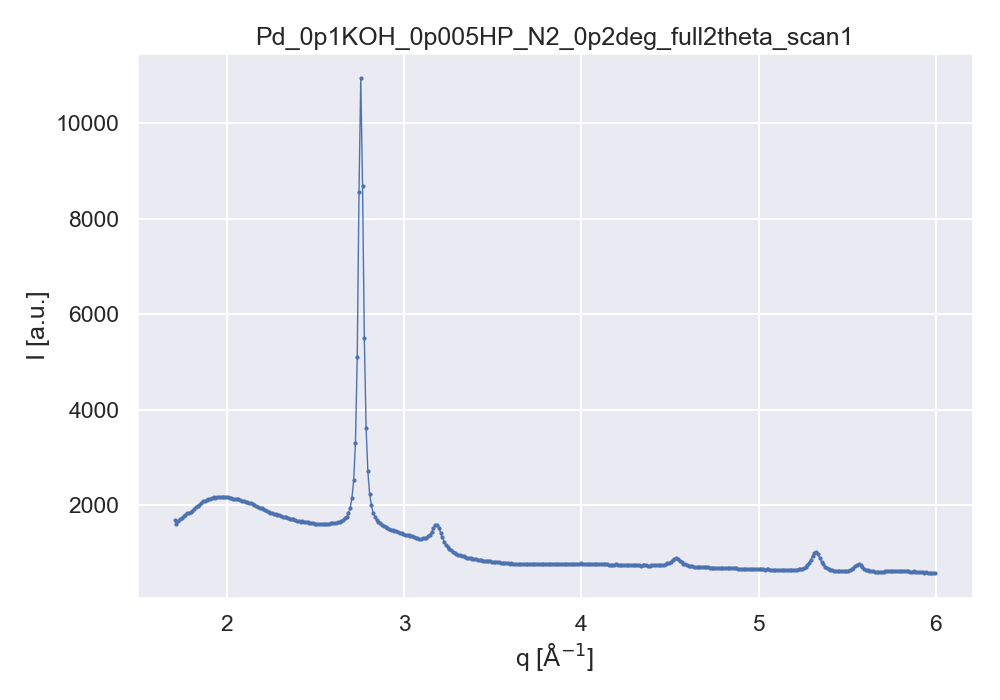

In [5]:
# Create the figure and axis for the plot
f1, f1_ax1 = plt.subplots(figsize=(10, 7), layout='tight')

# List to store labels for legend to avoid duplicate entries
labels = []

# List of available scans from the xy dictionary
processed_scans = list(xy.keys())

# Slider to select Nth dataset when iq is multidimensional
NSlider = ipy.IntSlider(min=0, max=1, step=1, value=0)

@ipy.interact(
    scan=ipy.Dropdown(options=processed_scans, value=processed_scans[-1]),  # Dropdown for selecting the scan
    N=NSlider,  # Slider to select the dataset when iq is multidimensional
    log=False,  # Toggle for log scale on the y-axis
    overlay=False  # Toggle for overlaying multiple scans
)
def show_iq(scan, N, log, overlay):
    """
    Plots the intensity (I) as a function of the momentum transfer (q) or 
    2θ angle (tth) from the selected scan data.

    Parameters:
    -----------
    Args:
        Scan (str): The key of the scan in the 'xy' dictionary.
        N (int): The index of the dataset within the scan.
        xaxis (str): The x-axis to use ('q' is the only option currently).
        log (bool): Whether to use a log scale for the y-axis.
        overlay (bool): Whether to overlay the plot on the existing axes.
    """

    # Clear plot and labels if overlay is not enabled
    if not overlay:
        f1_ax1.cla()
        labels.clear()

    # Extract scan data: q and iq are arrays
    q, iq = get_scan_data(scan)

    NSlider.max = len(iq) - 1  # Adjust slider range based on data
    q, iq = q[N], iq[N]  # Select the Nth dataset

    # Avoid duplicate labels in the legend when overlaying plots
    if f'{scan}_{N}' not in labels:
        yscale = 'log' if log else 'linear'
        xlabel = rf'q [${AA}$]'
        ylabel = 'I [a.u.]' if not log else 'log(I) [a.u.]'
        title = f'{scan}'

        plot_1D_data(f1_ax1, q, iq, fmt='o-', ms=2, lw=1, yscale=yscale, xlabel=xlabel, ylabel=ylabel, title=title)
        labels.append(f'{scan}_{N}')

# Fit

### Dictionaries and Pickle file for storing Fit Parameters

In [6]:
All_Fit_Data = OrderedDict()

fit_data_path = base_path / 'fit_data'
fit_data_path.mkdir(exist_ok=True)

fit_data_files = fit_data_path.glob('fit_data*.pkl')
All_Fit_Data = {f.stem:pickle.load(open(f, 'rb')) for f in fit_data_files}

[print(k) for k in All_Fit_Data.keys()]

fit_data_1peak_pvoigt
fit_data_1peaks_pvoigt


[None, None]

In [7]:
# Dictionaries
fit_data = pd.DataFrame(index=list(xy.keys()))
fit_cols = ['Cuts', 'FitPars', 'FitVals', 'All_PVals']
for col in fit_cols:
    fit_data[col] = [OrderedDict() for _ in range(len(fit_data.index))]

sigma = {'value':0.01}
slope = {'value':0}#, 'min':0, 'max':10}
funcs = ['pvoigt']#['pvoigt', 'gaussian']

fit_type = f"{len(funcs)}peaks_{funcs[0]}"
pickle_file = f'fit_data_{fit_type}.pkl'

try:
    print(pickle_file)
    Fit_Data = All_Fit_Data[pickle_file]
except KeyError:
    Fit_Data = OrderedDict({sample:OrderedDict() for sample in fit_data.index})

fit_data_1peaks_pvoigt.pkl


### Starting Values for Peak Fitting

In [8]:
Fit_Qs = {
    'Pd_111'    : dict(q0=[2.81], dq0=[0.1], q_range=(2.61, 3.01), hkl='1 1 1', phase='Pd'),
}
#q0 = center position ; dq0 = range q can vary ; q_range = range of fitting
# d0=[0.81,0.85] ; dq0=[0.5,0.5] for example would fit two peaks within the range

### Perform Batch Fitting

In [9]:
reprocess = False
num_cores = multiprocessing.cpu_count()

t0 = time.time()

scans = sorted(list(xy.keys()))
for scan in scans:
    q_all, iq_all = get_scan_data(scan)
    print(q_all.shape, iq_all.shape)
    print('\n{}'.format(scan))

    if scan not in Fit_Data.keys():
        Fit_Data[scan] = OrderedDict()

    for phase in list(Fit_Qs.keys())[:]:    
        print(phase, end='')
        q0, dq0, q_range = Fit_Qs[phase]['q0'], Fit_Qs[phase]['dq0'], Fit_Qs[phase]['q_range']
        
        dq = q_range[1] - q_range[0]
        if (q_all is None) or ((q_range[0] + dq/3) < q_all.min()) or ((q_range[1] - dq/3) > q_all.max()):
                print(f'  No Data in QRange {q_range}')
                continue
                  
        if (phase in Fit_Data[scan].keys()) and (not reprocess):
            print(' ')
            continue

        print('... Processing ')
        fits = []
        print(len(iq_all))
        for (q, iq) in zip(q_all, iq_all):
            q, iq, diq, q0s = get_centered_iq(q, iq, q_range, q0s=None, di_q=None)
            fit = get_fit(
                    q, iq, dy=None,
                    q0s=q0s, dq0s=[0.01],
                    funcs=funcs,
                    intercept={'value':0.0},
                    slope={'value':0.0},
                    sigma={'value':0.006},
                    vary=True
                )
            fits.append(fit)
    
        fit_data.FitPars[scan][phase] = [fit.params for fit in fits]
        fit_data.All_PVals[scan][phase] = get_pvals(fit_data, scan, phase)
        
        #q_f = np.linspace(q_all[0][0], q_all[0][-1], 1000)
        (q_all, iq_all), (x_fit, y_fit) = get_fit_raw_data(fits)
        Fit_Data[scan][phase] = dict(
            # cuts     = (q_all, i_q_all),
            cuts     = (q_all, iq_all),
            allPVals = fit_data.All_PVals[scan][phase],
            #fitVals  = [fit.eval(x=q_f) for fit in fits],
            fitVals  = (x_fit, y_fit),
            fitComps = [fit.eval_components() for fit in fits],
        )

        fitSigmas = []
        fitChis = []
        fitredChis = []
        for idx, fit in enumerate(fits):
            fitChis.append(fit.chisqr)
            fitredChis.append(fit.redchi)
            try:
                fitSigmas.append(fit.eval_uncertainty(sigma=2))
            except:
                fitSigmas.append(np.zeros( len(fits[idx].eval()) ))
                
        Fit_Data[scan][phase]['fitSigma'] = fitSigmas
        Fit_Data[scan][phase]['fitChi'] = fitChis
        Fit_Data[scan][phase]['fitredChi'] = fitredChis
        
    print('Done')
    pickle.dump(Fit_Data, open(os.path.join(fit_data_path, pickle_file), 'wb'))
    All_Fit_Data[pickle_file] = Fit_Data
    
    print(f'Total Processing Time: {time.time() - t0:0.2f} sec')

(1, 162) (1, 162)

50nmPd_3nmTi_Si_dry_XRR_scan1
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 0.02 sec
(1, 162) (1, 162)

50nmPd_3nmTi_Si_dry_XRR_scan2
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 0.04 sec
(1, 258) (1, 258)

50nmTi_Si_surface_0p2deg_XRD_scan1
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 0.07 sec
(1, 430) (1, 430)

Pd_0p1KOH_0p005HP_N2_0p2deg_full2theta_scan1
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 0.08 sec
(150, 175) (150, 175)

Pd_0p1KOH_0p005HP_N2_2deg_scan1
Pd_111... Processing 
150
150 150
Done
Total Processing Time: 1.73 sec


## Plot Individual Fits

interactive(children=(Dropdown(description='fit_type', index=2, options=('fit_data_1peak_pvoigt', 'fit_data_1p…

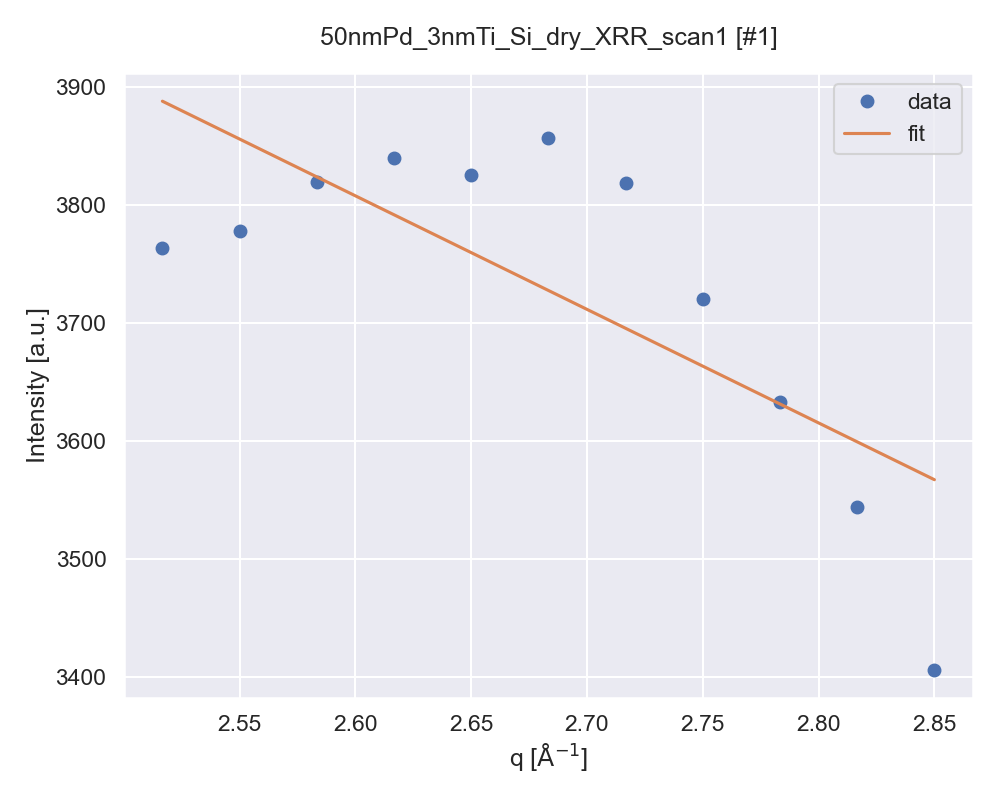

In [10]:
f4, f4_ax1 = plt.subplots(figsize=(10, 8))

fit_types = list(All_Fit_Data.keys())
Fits_Dict = All_Fit_Data[fit_types[-1]]
scans = [k for k, v in Fits_Dict.items() if len(v) > 0]
phases = list(Fit_Qs.keys())

phase_widget = Dropdown(options=phases)
n_widget = IntSlider(min=1, max=200, value=0, step=1)

n = len(Fits_Dict[scans[0]][phases[0]]['fitVals'][0])
@interact(fit_type=Dropdown(options=list(All_Fit_Data.keys()), value=fit_types[-1]),
          scan=Dropdown(options=scans, value=scans[0]),
          phase=phase_widget,
          n=n_widget,
          set_qRange=False, qRange=FloatRangeSlider(min=1.1, max=5.5, step=0.005, value=(2.54, 2.77)),
          show_comps=False, 
         )
def show_fit(fit_type, scan, phase, n, set_qRange, qRange, show_comps):
    f4_ax1.cla()
    
    Fits_Dict = All_Fit_Data[fit_type]

    # Reset Widget Options
    phase_widget.options = Fits_Dict[scan].keys()
    n_widget.max = len(Fits_Dict[scan][phase]['fitVals'][0])

    if set_qRange:
        q, i_q = get_iq(df, idxs=[n-1], q_range=qRange, return_sum=True)
    else:
        q, i_q = Fits_Dict[scan][phase]['cuts'][0][n-1], Fits_Dict[scan][phase]['cuts'][1][n-1]
    f4_ax1.plot(q, i_q, 'o', label='data')

    q_f, y_f = Fits_Dict[scan][phase]['fitVals'][0][n-1], Fits_Dict[scan][phase]['fitVals'][1][n-1]
    f4_ax1.plot(q_f, y_f, '-', label='fit')

    if show_comps:
        comps = Fits_Dict[scan][phase]['fitComps'][n-1]
        for k, comp in comps.items():
            #f4_ax1.plot(q[inds], comp[inds], '--', label=k)
            f4_ax1.plot(q, comp, '--', label=k)

    f4_ax1.set_xlabel(rf'q [${AA}$]')
    f4_ax1.set_ylabel('Intensity [a.u.]')
    f4_ax1.set_title(f'{scan} [#{n}]', pad = 20)

    f4_ax1.legend()
    
    f4.tight_layout()

## Plot Fit Parameters 

interactive(children=(Dropdown(description='scan', options=('50nmPd_3nmTi_Si_dry_XRR_scan1', '50nmPd_3nmTi_Si_…

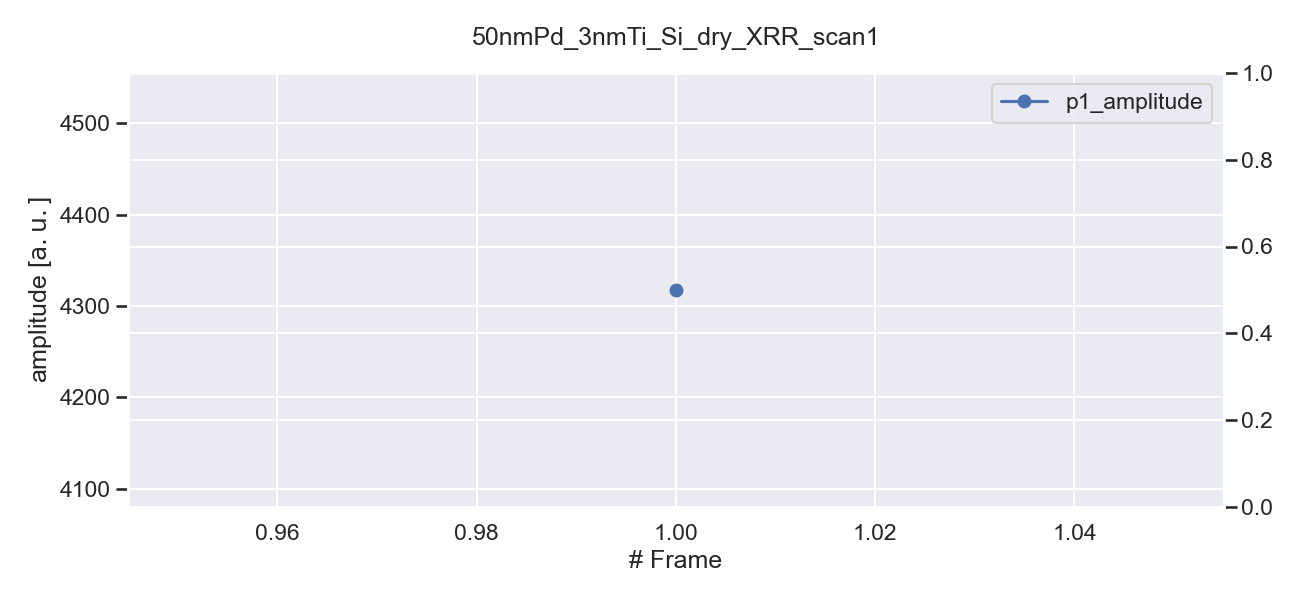

In [15]:
f3, ax_f3 = plt.subplots(figsize=(13, 6))
ax2_f3 = ax_f3.twinx()

fit_types = list(All_Fit_Data.keys())
Fits_Dict = All_Fit_Data[fit_types[-1]]

scans = [k for k, v in Fits_Dict.items() if len(v) > 0]
scan = scans[0]

phases = list(Fit_Data[scan].keys())
phase = phases[0]

fit_pars_all = list(Fit_Data[scan][phase]['allPVals'].keys())

phase_widget = Dropdown(options=phases)
fit_pars_widget = SelectMultiple(options=fit_pars_all, value=['p1_amplitude'])
sum_pars_widget = Checkbox(description='Sum Parameters')

units = dict(center=AA, sigma=AA)
Scan, Phase = None, None

X, Y = None, None

@interact(scan=Dropdown(options=scans, value=scans[0]),
          fit_type=Dropdown(options=list(All_Fit_Data.keys()), value=fit_types[-1]),
          phase=phase_widget, 
          fit_pars=fit_pars_widget,
          show_errors=False, sum_pars=sum_pars_widget
         )
def show_fit_par(scan, fit_type, phase, fit_pars, show_errors, sum_pars):
    [ax.cla() for ax in f3.get_axes()]
    
    global Scan, Phase, X, Y
    Fits_Dict = All_Fit_Data[fit_type]

    # Reset Widget Options
    phase_widget.options = Fits_Dict[scan].keys()
    fit_pars_widget.options = list(Fits_Dict[scan][phase]['allPVals'].keys())
        
    pval_sum, perr_sum, label_sum = 0, 0, []
    for fit_par in fit_pars:
        try:
            pval, perr = Fits_Dict[scan][phase]['allPVals'][fit_par]
        except KeyError:
            continue
                    
        perr[perr == None] = 0.0
        x = np.arange(1, len(pval)+1)
        
        X, Y = x, pval
        if not sum_pars:
            if show_errors:
                ax_f3.errorbar(x, pval, yerr=perr, fmt='o-', label=fit_par)
            else:
                ax_f3.plot(x, pval, 'o-', label=fit_par)
                                
                
        pval_sum += pval
        label_sum += [fit_par]
        
    if sum_pars:
        label_sum = '+'.join(label_sum)
        if show_errors:
            ax_f3.errorbar(x, pval_sum, yerr=perr_sum, fmt='o-', label=label_sum)
        else:
            ax_f3.plot(x, pval_sum, 'o-', label=label_sum)        

    ax_f3.set_xlabel(f'# Frame')
    
    # Get Y Axis Label
    y_unit = r'\mathrm{a.u.}'
    pars = [p[3:] if (p[0] == 'p') and (p[2] == '_') else p for p in fit_pars]
    ylabel = pars[0] if len(set(pars)) == 1 else '' 
    if ylabel in units.keys():
        y_unit = f'{units[ylabel]}'
    ax_f3.set_ylabel(rf'{ylabel} [${y_unit}$]')

    ax_f3.set_title(f'{scan}', pad = 20)
    ax_f3.legend()
    
    Scan, Phase = scan, phase
    f3.tight_layout()

In [ ]:
v

interactive(children=(Dropdown(description='fit_type', index=1, options=('fit_data_1peak_pvoigt', 'fit_data_1p…

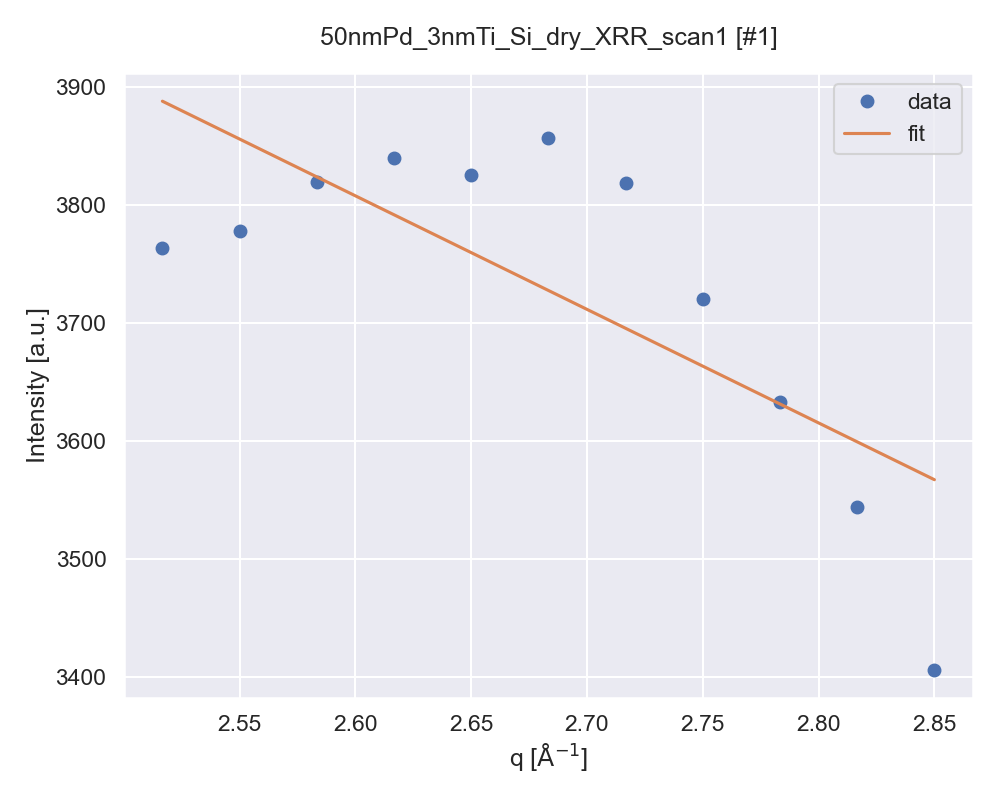

In [ ]:
f4, f4_ax1 = plt.subplots(figsize=(10, 8))

fit_types = list(All_Fit_Data.keys())
Fits_Dict = All_Fit_Data[fit_types[-1]]
scans = [k for k, v in Fits_Dict.items() if len(v) > 0]
phases = list(Fit_Qs.keys())

phase_widget = Dropdown(options=phases)
n_widget = IntSlider(min=1, max=200, value=0, step=1)

n = len(Fits_Dict[scans[0]][phases[0]]['fitVals'][0])
@interact(fit_type=Dropdown(options=list(All_Fit_Data.keys()), value=fit_types[-1]),
          scan=Dropdown(options=scans, value=scans[0]),
          phase=phase_widget,
          n=n_widget,
          set_qRange=False, qRange=FloatRangeSlider(min=1.1, max=5.5, step=0.005, value=(2.54, 2.77)),
          show_comps=False, 
         )
def show_fit(fit_type, scan, phase, n, set_qRange, qRange, show_comps):
    f4_ax1.cla()
    
    Fits_Dict = All_Fit_Data[fit_type]

    # Reset Widget Options
    phase_widget.options = Fits_Dict[scan].keys()
    n_widget.max = len(Fits_Dict[scan][phase]['fitVals'][0])

    #q_c, ii_c = Fits_Dict[scan][phase]['cuts'][0][n-1], Fits_Dict[scan][phase]['cuts'][1][n-1]
    #inds = np.s_[:]
    #q, ii = q_c, ii_c
    if set_qRange:
        q, i_q = get_iq(df, idxs=[n-1], q_range=qRange, return_sum=True)
    else:
        q, i_q = Fits_Dict[scan][phase]['cuts'][0][n-1], Fits_Dict[scan][phase]['cuts'][1][n-1]
        #inds = ( (q >= qRange[0]) & (q <= qRange[1]) )
    #ax_f2.plot(q[n-1, inds], ii[n-1, inds], 'o', label='data')
    #ax_f2.plot(q[n-1, inds], ii[n-1, inds], 'o', label='data')
    f4_ax1.plot(q, i_q, 'o', label='data')

    q_f, y_f = Fits_Dict[scan][phase]['fitVals'][0][n-1], Fits_Dict[scan][phase]['fitVals'][1][n-1]
    #q_f = np.linspace(q_c.min(), q_c.max(), len(y_f))        
    #q_f = np.linspace(q.min(), q.max(), len(y_f))        
    f4_ax1.plot(q_f, y_f, '-', label='fit')

    if show_comps:
        comps = Fits_Dict[scan][phase]['fitComps'][n-1]
        for k, comp in comps.items():
            #f4_ax1.plot(q[inds], comp[inds], '--', label=k)
            f4_ax1.plot(q, comp, '--', label=k)

    f4_ax1.set_xlabel(rf'q [${AA}$]')
    f4_ax1.set_ylabel('Intensity [a.u.]')
    f4_ax1.set_title(f'{scan} [#{n}]', pad = 20)

    f4_ax1.legend()
    
    f4.tight_layout()

In [ ]:
reprocess = True
num_cores = multiprocessing.cpu_count()

t0 = time.time()

# Define the function that processes each q, iq pair
def process_fit(q, iq, q_range, funcs):
    # Center the q and iq values
    q, iq, diq, q0s = get_centered_iq(q, iq, q_range, q0s=None, di_q=None)
    
    # Perform the fit
    fit = get_fit(
        q, iq, dy=None,
        q0s=q0s, dq0s=[0.01],
        funcs=funcs,
        intercept={'value': 0.0},
        slope={'value': 0.0},
        sigma={'value': 0.006},
        vary=True
    )
    
    return fit

# Parallelize the loop using joblib's Parallel and delayed

scans = sorted(list(xy.keys()))
for scan in scans:
    #fname, scan_num, q_all, iq_all = get_scan_data(scan)
    q_all, iq_all = get_scan_data(scan)
    print(q_all.shape, iq_all.shape)
    print('\n{}'.format(scan))

    if scan not in Fit_Data.keys():
        Fit_Data[scan] = OrderedDict()

    for phase in list(Fit_Qs.keys())[:]:    
        print(phase, end='')
        q0, dq0, q_range = Fit_Qs[phase]['q0'], Fit_Qs[phase]['dq0'], Fit_Qs[phase]['q_range']
        
        dq = q_range[1] - q_range[0]
        if (q_all is None) or ((q_range[0] + dq/3) < q_all.min()) or ((q_range[1] - dq/3) > q_all.max()):
                print(f'  No Data in QRange {q_range}')
                continue
                  
        if (phase in Fit_Data[scan].keys()) and (not reprocess):
            print(' ')
            continue

        # Center q_range around maximum intensity
        #i_q_all, q_all, q0s_all = get_centered_iq(i_q_all, q_all, q_range, q0)
        #print(q0s_all)
        
        print('... Processing ')
        # fits = Parallel(n_jobs=num_cores)(
        #     delayed(get_fit)(
        #         *get_centered_iq(q, i_q, q_range, q0, di_q=None), dq0s=dq0,
        #         funcs=funcs, sigma=sigma, slope=slope)
        #         #q, i_q, q0s=q0, dq0s=dq0, funcs=funcs, sigma=sigma, slope=slope)
        #         for (q, i_q) in zip(q_all[:2], i_q_all[:2])
        # )
        fits = []
        print(len(iq_all))

        fits = Parallel(n_jobs=-1)(delayed(process_fit)(q, iq, q_range, funcs) for q, iq in zip(q_all, iq_all))

        # Save the results
        fit_data.FitPars[scan][phase] = [fit.params for fit in fits]
        fit_data.All_PVals[scan][phase] = get_pvals(fit_data, scan, phase)

        #q_f = np.linspace(q_all[0][0], q_all[0][-1], 1000)
        (q_all, iq_all), (x_fit, y_fit) = get_fit_raw_data(fits)
        Fit_Data[scan][phase] = dict(
            # cuts     = (q_all, i_q_all),
            cuts     = (q_all, iq_all),
            allPVals = fit_data.All_PVals[scan][phase],
            #fitVals  = [fit.eval(x=q_f) for fit in fits],
            fitVals  = (x_fit, y_fit),
            fitComps = [fit.eval_components() for fit in fits],
        )

        fitSigmas = []
        fitChis = []
        fitredChis = []
        for idx, fit in enumerate(fits):
            fitChis.append(fit.chisqr)
            fitredChis.append(fit.redchi)
            try:
                fitSigmas.append(fit.eval_uncertainty(sigma=2))
            except:
                fitSigmas.append(np.zeros( len(fits[idx].eval()) ))
                
        Fit_Data[scan][phase]['fitSigma'] = fitSigmas
        Fit_Data[scan][phase]['fitChi'] = fitChis
        Fit_Data[scan][phase]['fitredChi'] = fitredChis
        
    print('Done')
    pickle.dump(Fit_Data, open(os.path.join(fit_data_path, pickle_file), 'wb'))
    All_Fit_Data[pickle_file] = Fit_Data
    
    print(f'Total Processing Time: {time.time() - t0:0.2f} sec')

(1, 162) (1, 162)

50nmPd_3nmTi_Si_dry_XRR_scan1
Pd_111... Processing 
1


1 1
Done
Total Processing Time: 10.37 sec
(1, 162) (1, 162)

50nmPd_3nmTi_Si_dry_XRR_scan2
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 10.94 sec
(1, 258) (1, 258)

50nmTi_Si_surface_0p2deg_XRD_scan1
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 11.49 sec
(1, 430) (1, 430)

Pd_0p1KOH_0p005HP_N2_0p2deg_full2theta_scan1
Pd_111... Processing 
1
1 1
Done
Total Processing Time: 11.51 sec
(150, 175) (150, 175)

Pd_0p1KOH_0p005HP_N2_2deg_scan1
Pd_111... Processing 
150
150 150
Done
Total Processing Time: 12.66 sec


In [ ]:
def plot_1D_data(ax, xy, **kwargs):
    for key, value in xy.items():
        ax.plot(value['x'], value['y'], label=key, **kwargs)
    ax.legend()

# Fitting 

## Fit Individual 1D Intensities

interactive(children=(Dropdown(description='scan', options=('50nmPd_3nmTi_Si_dry_XRR_scan1', '50nmPd_3nmTi_Si_…

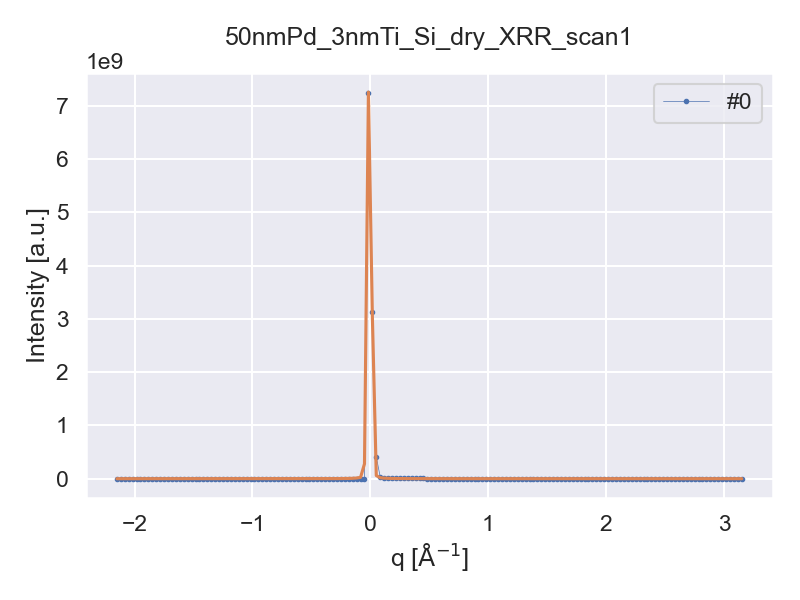

In [18]:

def get_iq_q_range(q, iq, q_range):
    inds = (q > q_range[0]) & (q < q_range[1])
    return q[inds], iq[inds]

f3, f3_ax1 = plt.subplots(ncols=1, figsize=(8, 6))

scans = list(xy.keys())
scan = scans[0]
fname, scan_num, q, iq = get_scan_data(scan)
q_range = (q[0][0], q[0][-1])

scan_widget = Dropdown(options=scans, value=scan)
npts_widget = IntSlider(min=0, max=len(q)-1, value=0, description='Image Number')
xlim_widget = FloatRangeSlider(min=q_range[0], max=q_range[1], value=q_range, step=0.1)
normChannel_widget = Dropdown(options=['None', 'sec', 'I0', 'bstop', 'I1', 'Monitor'], value='None', description='Normalize')
yoffset_widget = IntSlider(min=0, max=100, value=2, description='Y Offset')

def set_scan_pars(change):
    scan = change['new']
    fname, scan_num, q, iq = get_scan_data(scan)
    xlim_widget.min, xlim_widget.max = q_range    
    xlim_widget.value = (q[0][0], q[0][-1])

    npts_widget.max = len(q)-1
    npts_widget.value = 0

scan_widget.observe(set_scan_pars, names='value')

yoffset_plot, normLabel, last_normChannel = 0, None, None
plotted_data = {}

@interact(scan=scan_widget,
          N=npts_widget,
          auto_center=False,
          q_range=xlim_widget,
          log=False, continuous_update=False
         )
def fit_iq(scan, N, auto_center, q_range, log):
    global yoffset_plot, plotted_data, normLabel, last_normChannel

    f3_ax1.cla()

    fname, scan_num, q, iq = get_scan_data(scan)
    q, iq = q[N], iq[N]
    
    N = min(N, len(q)-1)
    npts_widget.value = N

    if auto_center:
        q, i_q, di_q, q0s = get_centered_iq(q, i_q, q_range, q0s=None, di_q=None)
    else:
        q, i_q = get_iq_q_range(q, iq, q_range)
        q0s = [q[np.argmax(i_q)]]
                
    # Fit
    fit = get_fit(
        q, i_q, dy=None,
        q0s=q0s, dq0s=[0.01],
        funcs=['pvoigt'],
        intercept={'value':0.0},
        slope={'value':0.0},
        sigma={'value':0.006},
        vary=True
    )
    y_fit = fit.eval()
    
    f3_ax1.plot(q, i_q, 'o-', label=f'#{N}', ms=3, lw=0.5)
    f3_ax1.plot(q, y_fit)
    if log:
        f3_ax1.set_yscale('log')
        
    f3_ax1.set_xlabel(rf'q [${AA}$]')
    f3_ax1.set_ylabel(f'Intensity [a.u.]')

    scan_label = scan
    if len(scan) > 50:
        scan_label = f'{scan[:20]} ... {scan[-20:]}'
    f3_ax1.set_title(f"{scan_label}", pad = 20)
    f3_ax1.legend()
        
    f3.tight_layout()
    
    #f3_ax1.set_ylabel(f'Intensity {normLabel} [a.u.]')

In [ ]:

@interact(
    x_col=Dropdown(value='time/s', options=df_echem.columns),
    y_col=Dropdown(value='Ewe/V', options=df_echem.columns),
    cycles=SelectMultiple(value=['all'], options=['all'] + n_cycles)
)
def plot_echem(x_col, y_col, cycles):
    f2_ax1.cla()
    
    if 'all' in cycles:
        x, y = df_echem[x_col], df_echem[y_col]
        f2_ax1.plot(x, y, 'o', ms=3, label='All')
    else:
        for cycle in cycles:
            x, y = df_echem[x_col][cycle_number==cycle], df_echem[y_col][cycle_number==cycle]
            f2_ax1.plot(x, y, 'o', ms=3, label=f'cycle #{cycle}')
    
    f2_ax1.set_xlabel(x_col)
    f2_ax1.set_ylabel(y_col)

interactive(children=(Dropdown(description='Scan', index=4, options=('50nmPd_3nmTi_Si_dry_XRR_scan1', '50nmPd_…

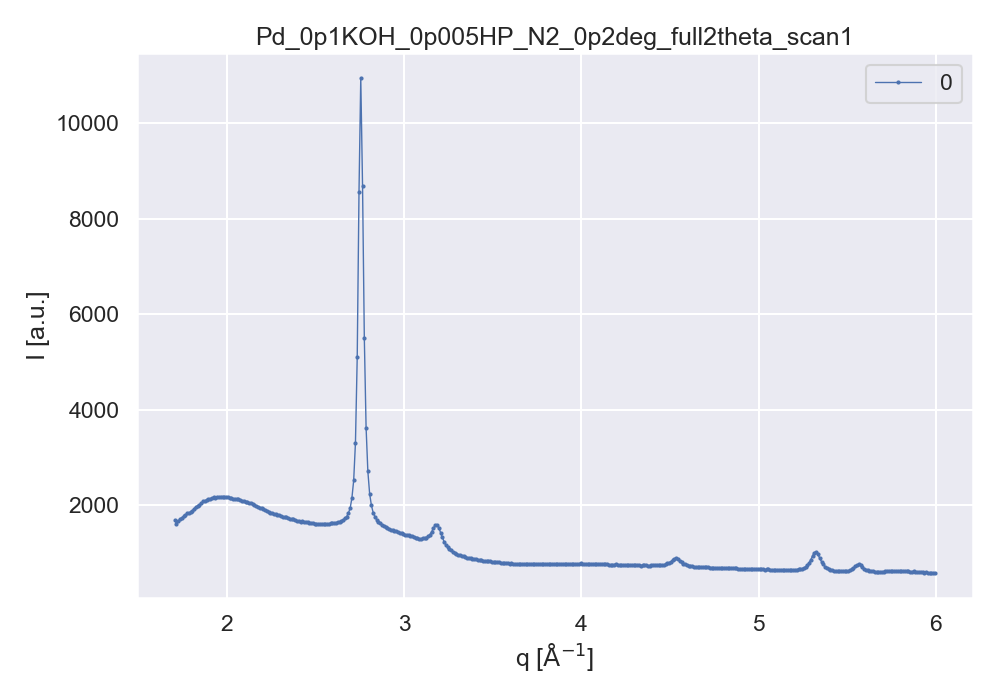

In [ ]:
f1, f1_ax1 = plt.subplots(ncols=1, figsize=(10, 7), layout='tight')

labels = []
processed_scans = list(xy.keys())
#xlim_widget = ipy.FloatRangeSlider(min=0, max=70, value=(1.4, 4.4), step=0.005)
#xlim_widget = ipy.FloatRangeSlider(step=0.1)
NSlider = ipy.IntSlider(min=0, max=1, step=1, value=0)

@ipy.interact(
    scan=ipy.Dropdown(options=processed_scans, value=processed_scans[-1]),
    N=NSlider,
    xaxis=ipy.Dropdown(options=['q', 'tth'], value='q'),
    log=False,
    overlay=False
)
# def show_iq(Scan, xaxis, xlim, log, overlay):
def show_iq(Scan, N, xaxis, log, overlay):
    if not overlay:
        f1_ax1.cla()
        labels.clear()
    # f1_ax1.grid(True)
    
    fname, scan_num, q, iq = xy[Scan]
    # q = 4 * np.pi * energy / 12.398 * np.sin(np.deg2rad(tth)/2)
    # tth = 2 * np.rad2deg( np.arcsin( 12.398 / (4 * np.pi * energy) * q) )

    if iq.ndim > 1:
        NSlider.max = len(iq)
        i_q = iq[N]
    else:
        NSlider.max = 0
        i_q = iq
        
    x, xlabel = q, f'q [${AA}$]'
    # if xaxis == 'tth':
    #     x, xlabel = tth, rf'2$\theta$ [$^o$]'
    #xlim_widget.value = (x.min(), x.max())

    if f'{Scan}_{N}' not in labels:
        f1_ax1.plot(x, i_q, 'o-', ms=2, lw=1, label=N)
        labels.append(f'{Scan}_{N}')
    
    #ax2.set_xlim(xlim)
    f1_ax1.set_xlabel(xlabel)
    f1_ax1.set_ylabel('I [a.u.]')
    if log:
        f1_ax1.set_yscale('log')
        f1_ax1.set_ylabel('log(I) [a.u.]')
        
    f1_ax1.set_title(f'{Scan}')
    f1_ax1.legend()

# Get Spline
    y_spl = UnivariateSpline(x, y, s=0, k=4)
    x_range = np.linspace(x.iloc[0], x.iloc[-1], 1000)
    print(x.iloc[0], x.iloc[-1])
    #f2_ax1.plot(x_range, y_spl(x_range), label='Fit', color='r')

    # Get Derivative
    y_spl_1d = y_spl.derivative(n=1)
    #f2_ax1.plot(x_range, y_spl_1d(x_range), label='First Derivative', color='g')
    
    #f2_ax1.plot(x, np.gradient(np.gradient(y, x), x), 'o-', label='Derivative', color='r', ms=3, lw=0.5)

    f2_ax1.plot(x[1:], np.diff(y)*5, 'o-', label='Derivative', color='r', ms=3, lw=0.5)

    #plt.legend()